In [1]:
import re
import string
from unicodedata import normalize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import gensim
import pandas as pd
import spacy
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np

In [2]:
nlp = spacy.load('es_core_news_sm')

In [3]:
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop
esp_stop.remove('estado')

In [4]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc if word.lemma_ not in esp_stop])
  #return ' '.join([ps.stem(word.text) for word in doc if word.text not in esp_stop])

In [5]:
nlp = spacy.load('es_core_news_sm')

In [6]:
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop
esp_stop.remove('estado')

In [7]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc if word.lemma_ not in esp_stop])

In [8]:
def preprocess(df, column):
    articles = df

    articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
    articles[column] = articles[column].str.strip()
    articles[column] = articles[column].str.replace('\n', ' ')
    articles[column] = articles[column].str.replace('nº', ' ')
    articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
    articles[column] = articles[column].apply(lambda x: " ".join(x.split()))
    articles[column] = articles[column].apply(
        lambda x: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
                         normalize("NFD", x), 0, re.I))

    articles = articles[[len(str(x).split()) > 2 for x in articles[column]]]
    return articles.reset_index(drop=True)

### Apertura archivo y preprocesamiento

In [9]:
with open("data/nc_ch_chapters.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_chapters = data.split("--capitulo--")

In [10]:
df_charperts = pd.DataFrame(list_chapters, columns=["chapter"])

In [11]:
df_charperts_p = preprocess(df_charperts, "chapter")

In [12]:
corpus_chapters = [word_tokenize(lemmatizer(i)) for i in df_charperts_p["chapter"]]

In [13]:
dict_corpus_chapter = corpora.Dictionary(corpus_chapters)

dtm_gensim_chapters = [dict_corpus_chapter.doc2bow(i) for i in corpus_chapters]
dtm_gensim_tfidf_chapters = models.TfidfModel(dtm_gensim_chapters)[dtm_gensim_chapters]

In [14]:
lda_gensim_chapters = gensim.models.ldamodel.LdaModel
ldamodel_gensim_chapters = lda_gensim_chapters(
    dtm_gensim_tfidf_chapters,
    num_topics = 8,
    passes = 1000,
    id2word = dict_corpus_chapter,
    random_state = 0,
    eval_every = None,
    alpha = 'auto'
)

In [15]:
ldamodel_gensim_chapters.print_topics(
    num_words = 15,
    num_topics = 49
)

[(0,
  '0.000*"correcta" + 0.000*"correspondencia" + 0.000*"conferida" + 0.000*"consagra" + 0.000*"consecutivamente" + 0.000*"contraloria" + 0.000*"contrato" + 0.000*"convenio" + 0.000*"convocar" + 0.000*"convocatoria" + 0.000*"coordinadamente" + 0.000*"correccion" + 0.000*"concretar" + 0.000*"delimitacion" + 0.000*"demandar"'),
 (1,
  '0.001*"dignidad" + 0.001*"corrupcion" + 0.001*"portuario" + 0.001*"reconocimiento" + 0.001*"reconocer" + 0.001*"emblema" + 0.001*"rendicion" + 0.001*"tributario" + 0.001*"buen" + 0.001*"vida" + 0.001*"pueblo" + 0.001*"eficiente" + 0.001*"economia" + 0.001*"pertinencia" + 0.001*"capacitacion"'),
 (2,
  '0.000*"correcta" + 0.000*"correspondencia" + 0.000*"conferida" + 0.000*"consagra" + 0.000*"consecutivamente" + 0.000*"contraloria" + 0.000*"contrato" + 0.000*"convenio" + 0.000*"convocar" + 0.000*"convocatoria" + 0.000*"coordinadamente" + 0.000*"correccion" + 0.000*"concretar" + 0.000*"delimitacion" + 0.000*"demandar"'),
 (3,
  '0.001*"presidenta" + 0.001

In [16]:
df_topic_term_chapters = pd.DataFrame(
    ldamodel_gensim_chapters.get_topics(),
    columns=ldamodel_gensim_chapters.id2word.values(),
    index=[f'topic{i}' for i in range(ldamodel_gensim_chapters.num_topics)]
)

df_topic_term_chapters.sort_values(by=df_topic_term_chapters.columns.values.tolist(), ascending=False)

,acceso,accion,actividad,acto,actuan,actuar,adecuado,adecuar,administracion,adoptar,...,undecimo,usted,veinticinco,vencer,versen,vista,¿,“,”,…
topic5,0.000443,0.000457,0.000326,0.000274,0.000266,0.000271,0.000316,0.000266,0.000266,0.000317,...,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266,0.000266
topic1,0.000346,0.000325,0.000352,0.000281,0.000443,0.000346,0.000307,0.000428,0.000272,0.000307,...,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272,0.000272
topic4,0.000308,0.000304,0.000298,0.000289,0.000281,0.000294,0.000310,0.000281,0.000281,0.000305,...,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281,0.000281
topic7,0.000296,0.000423,0.000294,0.000283,0.000269,0.000277,0.000287,0.000269,0.000269,0.000297,...,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269
topic0,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,...,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292
topic2,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,...,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292
topic6,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,...,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292,0.000292
topic3,0.000256,0.000251,0.000274,0.000278,0.000251,0.000273,0.000274,0.000417,0.000251,0.000273,...,0.000279,0.000310,0.000279,0.000279,0.000279,0.000279,0.000310,0.000373,0.000373,0.000279


In [17]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda_chapters = CoherenceModel(model=ldamodel_gensim_chapters, texts=corpus_chapters, dictionary=dict_corpus_chapter, coherence='c_v')
coherence_lda_chapters = coherence_model_lda_chapters.get_coherence()
print('\nCoherence Score: ', coherence_lda_chapters)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim_chapters.log_perplexity(dtm_gensim_tfidf_chapters))  # a measure of how good the model is. lower the better.


Coherence Score:  0.5022070558045553

Perplexity:  -13.176718313430271


In [20]:
def get_max(doc):
    idx, l = zip(*doc)
    return idx[np.argmax(l)] , l[np.argmax(l)]

tpc = [get_max(doc) for doc in ldamodel_gensim_chapters[dtm_gensim_tfidf_chapters]]
df_tpc = pd.DataFrame(tpc, columns =['topico', 'prop'])
df_tpc['doc'] = df_tpc.index
df_tpc[df_tpc["topico"]==1].sort_values('prop',ascending=False).head()

,topico,prop,doc
4,1,0.997543,4
0,1,0.996894,0


In [22]:
df_charperts_p['chapter'][4]

'buen gobierno y funcion publica el ejercicio de las funciones publicas obliga a sus titulares a dar cumplimiento a los principios de probidad transparencia y rendicion de cuentas en todas sus actuaciones ademas se rige por los principios de eficiencia eficacia responsabilidad publicidad buena fe interculturalidad enfoque de genero inclusion no discriminacion y sustentabilidad la funcion publica se debera brindar con pertinencia territorial cultural y linguistica el principio de probidad consiste en observar una conducta funcionaria responsable e intachable desempeñando la funcion o el cargo correspondiente en forma leal honesta objetiva e imparcial sin incurrir en discriminaciones de ningun tipo con preeminencia del interes general por sobre el particular las autoridades electas y demas autoridades funcionarias y funcionarios que determine la ley deberan declarar sus intereses y patrimonio en forma publica la ley regulara los casos y las condiciones en las que delegaran a terceros la

In [23]:
df_charperts_p

,chapter
0,chile es un estado social y democratico de der...
1,los derechos fundamentales son inherentes a la...
2,la naturaleza tiene derechos el estado y la so...
3,en chile la democracia se ejerce en forma dire...
4,buen gobierno y funcion publica el ejercicio d...
5,el estado se organiza territorialmente en enti...
6,poder legislativo el poder legislativo se comp...
7,poder ejecutivo el gobierno y la administracio...
8,la jurisdiccion es una funcion publica que se ...
9,todos los organos autonomos se rigen por el pr...


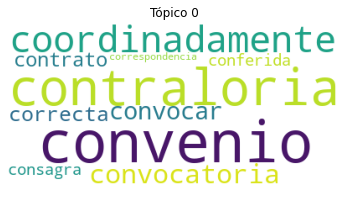

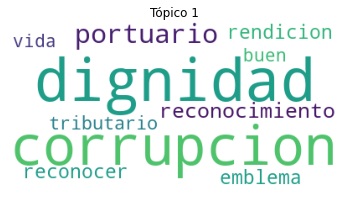

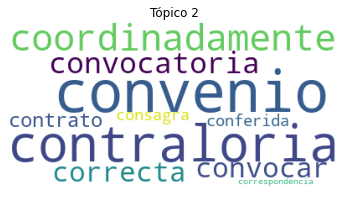

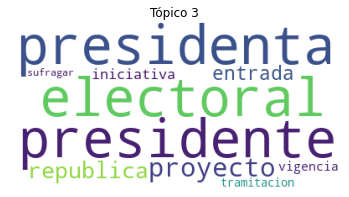

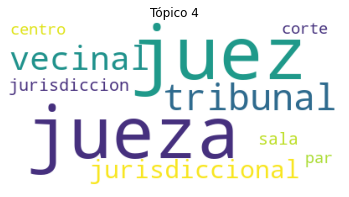

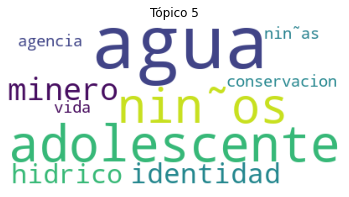

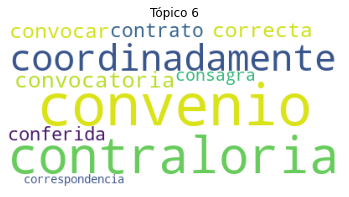

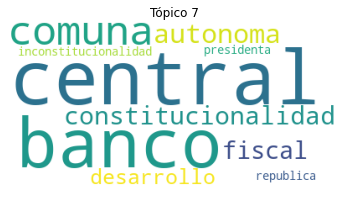

In [25]:
for i in range(0, 8):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim_chapters.show_topic(i, 10)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()